# Learning Auctions: Are incentives constraints needed in learning?

In this tutorial, we will consider whether or not the DSIC violations are essential to learning.  We note that the IR violations are, otherwise the mechanism can simply learn to charge an arbitrarily large positive amount and always allocate the item.  A rational bidder would prefer to not participate in such a market.

## Architectures and supporting functions

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders+1]`.  The first column represents the probability that the item is not allocated, with all other columns representing the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x):
        allocation = self.allocation_rule(x)
        return allocation, allocation[:,1:] * self.payment_rule(x)

Utility can thusly be calculated by:

In [4]:
def calc_utility(bids, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids)
    if output_components:
        return allocation[:,1:]*valuation-payment, allocation, payment
    else:
        return allocation[:,1:]*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DSIC, we calculate regret:

In [5]:
def calc_regret(values, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility(values, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility(response, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

Finally, we can define the training function.

In [6]:
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm import tqdm

def train_without_dsic(mechanism, learning_bidders, values_loader, epochs=1, rho=100):
    # Initialize augmented lagrangian parameters
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    bidder_optimizers = [optim.Adam(b.parameters(), lr=1e-3) for b in learning_bidders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            bids = values.clone()
            for learning_bidder in learning_bidders:
                bids = learning_bidder(bids)
                
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                bids, mechanism, output_components=True)
        
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                u_next = calc_utility(bids, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
                
            for bidder in range(bidders):
                optimizer = bidder_optimizers[bidder]
                optimizer.zero_grad()
                
                bids = values.clone()
                for learning_bidder in learning_bidders:
                    bids = learning_bidder(bids)
                
                utility = calc_utility(bids, mechanism, valuation = values)
                
                (-utility[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)    

def train_with_dsic(mechanism, learning_bidders, responders, values_loader, epochs=1, rho=100):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-3) for r in responders]
    bidder_optimizers = [optim.Adam(b.parameters(), lr=1e-3) for b in learning_bidders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            bids = values.clone()
            for learning_bidder in learning_bidders:
                bids = learning_bidder(bids)
                
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                bids, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret(
                bids, 
                mechanism,
                responders)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret(
                    bids,
                    mechanism,
                    responders)
                u_next = calc_utility(bids, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                
                bids = values.clone()
                for learning_bidder in learning_bidders:
                    bids = learning_bidder(bids)
                    
                regret = calc_regret(
                    bids, 
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
                
            for bidder in range(bidders):
                optimizer = bidder_optimizers[bidder]
                optimizer.zero_grad()
                
                bids = values.clone()
                for learning_bidder in learning_bidders:
                    bids = learning_bidder(bids)
                
                utility = calc_utility(bids, mechanism, valuation = values)
                
                (-utility[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)     

## Learning Bidders

The bidding network computes the best bid for the mechanism.

In [7]:
class LearningBidder(nn.Module):
    def __init__(self, bidder, hidden_units):
        super(LearningBidder, self).__init__()
        self.bidder = bidder
        self.initial_layer = nn.Linear(1, hidden_units)
        self.hidden_layer = nn.Linear(hidden_units, hidden_units)
        self.final_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, values):
        x = values[:,self.bidder].unsqueeze(1)
        x = F.leaky_relu(self.initial_layer(x))
        x = F.leaky_relu(self.hidden_layer(x))
        x = torch.sigmoid(self.final_layer(x))
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,self.bidder] = 1.0
        return (1-bidder_mask)*values + bidder_mask * values * x

## Responder

The responder network computes the best response to the mechanism.

In [8]:
class Responder(nn.Module):
    def __init__(self, bidder, hidden_units):
        super(Responder, self).__init__()
        self.bidder = bidder
        self.initial_layer = nn.Linear(2, hidden_units)
        self.hidden_layer = nn.Linear(hidden_units, hidden_units)
        self.final_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, values, allocation, payment):
        x = torch.cat((allocation[:,self.bidder+1].unsqueeze(1), payment[:,self.bidder].unsqueeze(1)), dim=1)
        x = F.leaky_relu(self.initial_layer(x))
        x = F.leaky_relu(self.hidden_layer(x))
        x = torch.sigmoid(self.final_layer(x))
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,self.bidder] = 1.0
        return (1-bidder_mask)*values + bidder_mask * values * x

## RegretNet

[Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf) proposed a network of the following form.  We give a pytorch implementation of the network with minor modifications to the activation funtions.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The allocation network is defined as follows:

In [10]:
class RegretNetAllocation(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders+1))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))
        return F.softmax(self.fc_layers[-1](x), dim=1)

The payment network is defined as follows:

In [11]:
class RegretNetPayment(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers:
            x = F.leaky_relu(layer(x))
        return x

Finally, we can define the RegretNet mechanism.  Note that the output activation function used by Dutting et al. was the `relu`.  In the examples below we use `leaky_relu`.

In [12]:
def create_regret_net(bidders, hidden_layers=2, hidden_units=100):
    return MechanismNet(
        RegretNetAllocation(bidders, hidden_layers, hidden_units),
        RegretNetPayment(bidders, hidden_layers, hidden_units))

## Single-Item Auction

As in the intro tutorial we consider only a single bidder.  From Myerson (81), we know that the optimal mechanism is a fixed price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder passing on the item, with the other half accepting at a price of 0.5.  Therefore, the optimal expected revenue is 0.25.

However, unlike in the previous tutorial, we allow the bidder to learn as well.  The mechanism does not get to observe the values directly.

In [13]:
bidders = 1

The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [14]:
sample_size = 2**11
batch_size = 2**8

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

We consider both the mechanism and responder networks.

In [15]:
without_regret_net = create_regret_net(bidders).to(device)
without_regret_net_bidders = [LearningBidder(bidder, 100).to(device) for bidder in range(bidders)]

with_regret_net = create_regret_net(bidders).to(device)
with_regret_net_bidders = [LearningBidder(bidder, 100).to(device) for bidder in range(bidders)]
with_regret_net_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

We loop over the data for a number of epochs and record traces of the networks learning.

In [16]:
epochs = 1000
without_report = train_without_dsic(without_regret_net, without_regret_net_bidders, values_loader, epochs=epochs)
with_report = train_with_dsic(with_regret_net, with_regret_net_bidders, with_regret_net_responders, values_loader, epochs=epochs)

100%|██████████| 1000/1000 [04:42<00:00,  8.54it/s]


First, let's review the IR violations of the network.  In the figure below, we can see that RegretNet quickly optimizes to vanishingly small IR violations.

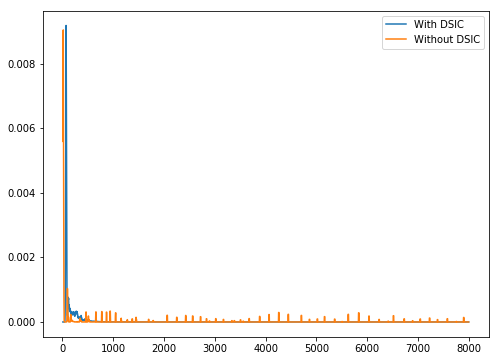

In [17]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(with_report[['total_ir_violation']].rolling(10).mean(), label='With DSIC');
ax.plot(without_report[['total_ir_violation']].rolling(10).mean(), label='Without DSIC');
ax.legend();

Next, let's review the DSIC violations. RegretNet quickly optimizes to epsilon violations.

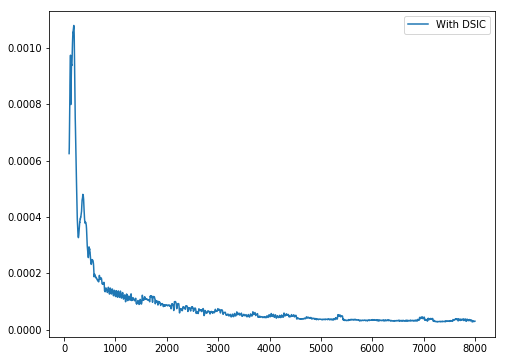

In [18]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(with_report[['total_dsic_violation']].rolling(100).mean(), label='With DSIC');
ax.legend();

Finally, let's review the revenue.  RegretNet quickly converges to the optimal revenue when DSIC violations are considered and zero when they are not.

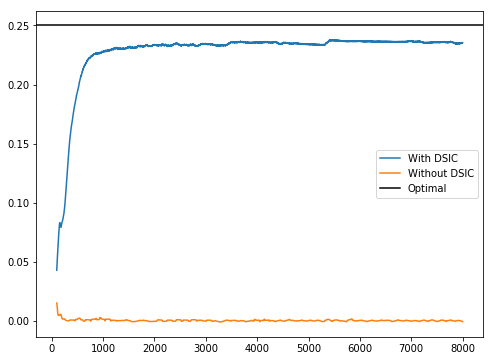

In [19]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(with_report[['revenue']].rolling(100).mean(), label='With DSIC');
ax.plot(without_report[['revenue']].rolling(100).mean(), label='Without DSIC');
ax.axhline(0.25, c='k', label='Optimal')
ax.legend();

While we have not shown that DSIC constraints are necessary for learning optimal mechanism, we have shown that the bidder does not quickly learn to shade their bid as in the case of RegretNet learning without DSIC constraints.